In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Load Dataset**

In [0]:
data_dir = '/content/drive/My Drive/A05_DL_Dataset'

In [0]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train':trainloader, 'val':validloader}

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


**Training Function**

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    err_tr = []
    err_val = []
    acc_tr = []
    acc_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(phase, epoch_loss, epoch_acc*100))
            
            if phase == 'train':
                err_tr.append(epoch_loss)
                acc_tr.append(epoch_acc*100)
            else:
                err_val.append(epoch_loss)
                acc_val.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, err_tr, acc_tr, err_val, acc_val

*** ----------------> VGG-16 Model <---------------- ***

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze all the layers except the last FC layers
for param in vgg16.parameters():
    param.requires_grad = True

# for i in [17,19,21,24,26,28]:
#     for param in vgg16.features[i].parameters():
#         param.requires_grad = True

# Fully connected layer architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( vgg16.classifier[0].in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )

# Modifying dense layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*fc_layers)

# Unfreeze FC layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# Printing modified VGG16 architecture
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Printing parameter that needs to be updated for VGG16

for name, param in vgg16.named_parameters():
    if param.requires_grad:
       print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [0]:
vgg16 = vgg16.to(device)

In [0]:
##### training
model_vgg, err_tr, acc_tr, err_val, acc_val = train_model( vgg16, criterion, optimizer, num_epochs = 10 )

Epoch 1/10
----------------------------------------
train ==> Loss: 0.5028 , Acc: 75.75 %
val ==> Loss: 0.3543 , Acc: 85.33 %

Epoch 2/10
----------------------------------------
train ==> Loss: 0.3541 , Acc: 85.28 %
val ==> Loss: 0.2977 , Acc: 87.07 %

Epoch 3/10
----------------------------------------
train ==> Loss: 0.3171 , Acc: 86.78 %
val ==> Loss: 0.2712 , Acc: 88.07 %

Epoch 4/10
----------------------------------------
train ==> Loss: 0.2860 , Acc: 88.03 %
val ==> Loss: 0.2682 , Acc: 87.93 %

Epoch 5/10
----------------------------------------
train ==> Loss: 0.2776 , Acc: 88.57 %
val ==> Loss: 0.2534 , Acc: 89.53 %

Epoch 6/10
----------------------------------------
train ==> Loss: 0.2657 , Acc: 89.45 %
val ==> Loss: 0.2509 , Acc: 90.13 %

Epoch 7/10
----------------------------------------
train ==> Loss: 0.2574 , Acc: 89.70 %
val ==> Loss: 0.2498 , Acc: 90.07 %

Epoch 8/10
----------------------------------------
train ==> Loss: 0.2482 , Acc: 90.16 %
val ==> Loss: 0.2399 

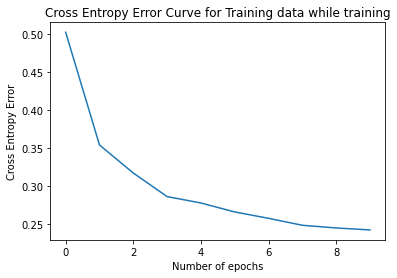

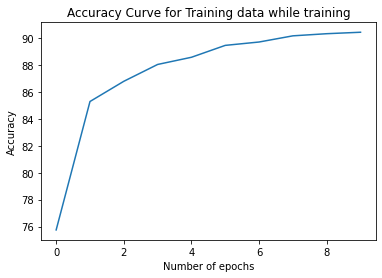

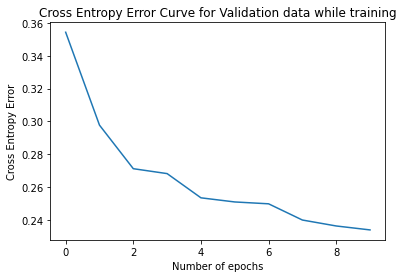

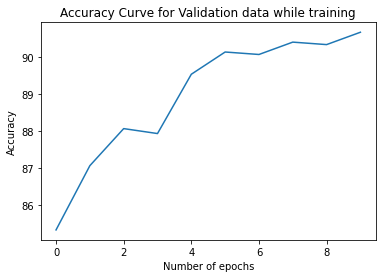

In [0]:
plt.plot( range(10) , err_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Training data while training')
plt.show()
plt.plot( range(10) , acc_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Training data while training')
plt.show()
plt.plot( range(10) , err_val )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Validation data while training')
plt.show()
plt.plot( range(10) , acc_val )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Validation data while training')
plt.show()

In [0]:
torch.save(model_vgg.state_dict(), '/content/drive/My Drive/vgg16_FC_Entire.pth')

In [0]:
#### TESTING

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Testing data Accuracy: %d %%' % (100 * correct / total))

Testing data Accuracy: 96 %


*********************************************

*********************************************

*********************************************

*********************************************

*** ----------------> ResNet-18 Model <----------------  ***

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

# Freeze all the layers except the last FC layers
for param in resnet18.parameters():
    param.requires_grad = True

# for param in resnet18.layer4.parameters():
#     param.requires_grad = True

# for param in resnet18.layer4[1].conv2.parameters():
#     param.requires_grad = True
# for param in resnet18.layer4[1].bn2.parameters():
#     param.requires_grad = True

# Modifying dense layers in VGG16 architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( resnet18.fc.in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )
resnet18.fc = nn.Sequential( *fc_layers )

# Unfreeze FC layers
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Printing modified VGG16 architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Printing parameter that needs to be updated for ResNet18

for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

In [0]:
resnet18 = resnet18.to(device)

In [0]:
##### training
model_resnet, err_tr, acc_tr, err_val, acc_val = train_model( resnet18, criterion, optimizer, num_epochs = 10 )

Epoch 1/10
----------------------------------------
train ==> Loss: 0.6035 , Acc: 67.48 %
val ==> Loss: 0.4745 , Acc: 80.20 %

Epoch 2/10
----------------------------------------
train ==> Loss: 0.4725 , Acc: 80.33 %
val ==> Loss: 0.3936 , Acc: 83.47 %

Epoch 3/10
----------------------------------------
train ==> Loss: 0.4035 , Acc: 83.28 %
val ==> Loss: 0.3587 , Acc: 84.87 %

Epoch 4/10
----------------------------------------
train ==> Loss: 0.3684 , Acc: 84.76 %
val ==> Loss: 0.3365 , Acc: 85.80 %

Epoch 5/10
----------------------------------------
train ==> Loss: 0.3429 , Acc: 85.78 %
val ==> Loss: 0.3227 , Acc: 86.67 %

Epoch 6/10
----------------------------------------
train ==> Loss: 0.3256 , Acc: 86.84 %
val ==> Loss: 0.3082 , Acc: 88.27 %

Epoch 7/10
----------------------------------------
train ==> Loss: 0.3163 , Acc: 87.14 %
val ==> Loss: 0.2985 , Acc: 88.13 %

Epoch 8/10
----------------------------------------
train ==> Loss: 0.3026 , Acc: 87.33 %
val ==> Loss: 0.2886 

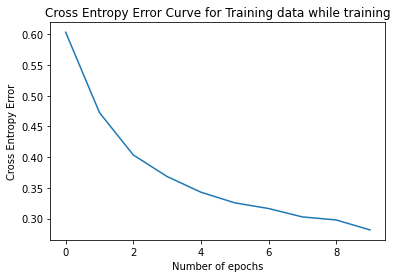

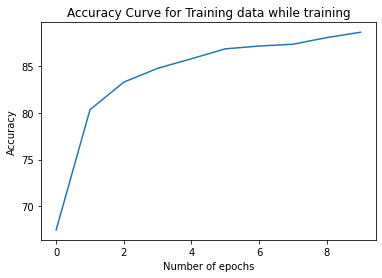

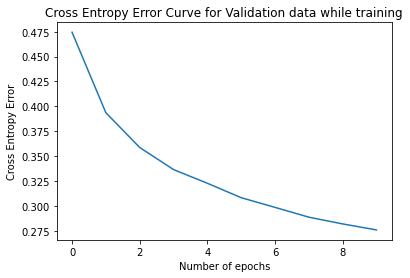

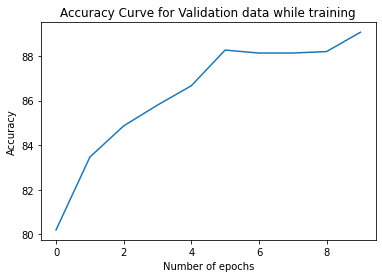

In [0]:
plt.plot( range(10) , err_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Training data while training')
plt.show()
plt.plot( range(10) , acc_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Training data while training')
plt.show()
plt.plot( range(10) , err_val )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Validation data while training')
plt.show()
plt.plot( range(10) , acc_val )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Validation data while training')
plt.show()

In [0]:
torch.save(model_resnet.state_dict(), '/content/drive/My Drive/res18_FC_Entire.pth')

In [0]:
#### TESTING

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Testing data Accuracy: %d %%' % (100 * correct / total))

Testing data Accuracy: 95 %


*********************************************

*********************************************

*********************************************

*********************************************

*** ----------------> F1-SCORES AND CONFUSION MATRICES <---------------- ***

***Loading VGG16 Model***

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze all the layers except the last FC layers
for param in vgg16.parameters():
    param.requires_grad = False

# Fully connected layer architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( vgg16.classifier[0].in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )

# Modifying dense layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*fc_layers)

# Unfreeze FC layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# printing trainable parameters
for name, param in vgg16.named_parameters():
    if param.requires_grad:
       print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/vgg16_FC_Only.pth'))
vgg16 = vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

***Loading ResNet18 Model***

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

# Freeze all the layers except the last FC layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modifying dense layers in VGG16 architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( resnet18.fc.in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )
resnet18.fc = nn.Sequential( *fc_layers )

# Unfreeze FC layers
for param in resnet18.fc.parameters():
    param.requires_grad = True

# printing trainable parameters
for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name)

fc.0.weight
fc.0.bias
fc.3.weight
fc.3.bias


In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/res18_FC_Only.pth'))
resnet18 = resnet18.to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

***Finding Predictions for Training, Validation and Testing Data***

In [0]:
#### Training
Y_act_train = np.array([])
Y_pred_train = np.array([])
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        Y_act_train = np.append( Y_act_train , np.array(labels.cpu()) )
        Y_pred_train = np.append( Y_pred_train , np.array(predicted.cpu()) )

In [0]:
#### Validation
Y_act_val = np.array([])
Y_pred_val = np.array([])
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        Y_act_val = np.append( Y_act_val , np.array(labels.cpu()) )
        Y_pred_val = np.append( Y_pred_val , np.array(predicted.cpu()) )

In [0]:
#### Testing
Y_act_test = np.array([])
Y_pred_test = np.array([])
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        Y_act_test = np.append( Y_act_test , np.array(labels.cpu()) )
        Y_pred_test = np.append( Y_pred_test , np.array(predicted.cpu()) )

***Generating F1-Scores and Confusion Matrices***

F1 score: 0.886610621283576


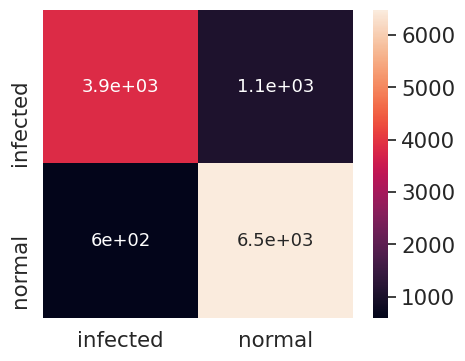

In [0]:
# For Training Data

print('F1 score:', f1_score(Y_act_train, Y_pred_train))
matrix = confusion_matrix(Y_act_train, Y_pred_train)
df_cm = pd.DataFrame(matrix, ['infected', 'normal'], ['infected', 'normal'])
plt.figure(figsize=(5,4))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})

F1 score: 0.8869374313940724


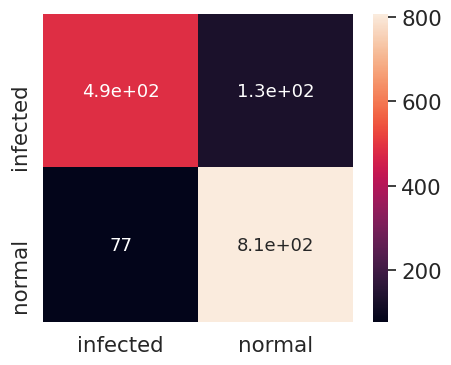

In [0]:
# For Validation Data

print('F1 score:', f1_score(Y_act_val, Y_pred_val))
matrix = confusion_matrix(Y_act_val, Y_pred_val)
df_cm = pd.DataFrame(matrix, ['infected', 'normal'], ['infected', 'normal'])
plt.figure(figsize=(5,4))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})

F1 score: 0.9403393541324575


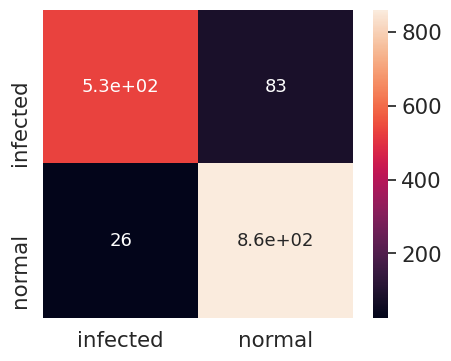

In [0]:
# For Testing Data

print('F1 score:', f1_score(Y_act_test, Y_pred_test))
matrix = confusion_matrix(Y_act_test, Y_pred_test)
df_cm = pd.DataFrame(matrix, ['infected', 'normal'], ['infected', 'normal'])
plt.figure(figsize=(5,4))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})

*** ----------------> Well and Worst classified Images <---------------- ***

In [0]:
# Generating Indices of well and worst classified images

inf_true = np.where( (Y_act_test==0) & (Y_pred_test==0) )[0]
inf_false = np.where( (Y_act_test==0) & (Y_pred_test==1) )[0]
nor_true = np.where( (Y_act_test==1) & (Y_pred_test==1) )[0]
nor_false = np.where( (Y_act_test==1) & (Y_pred_test==0) )[0]
print( len(inf_true), len(inf_false), len(nor_true), len(nor_false) )

532 83 859 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FOR INFECTED CLASS
 ========> Best Classified <======== 


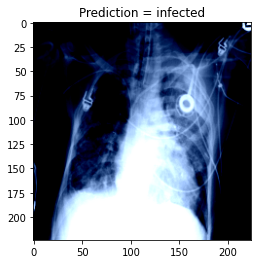

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


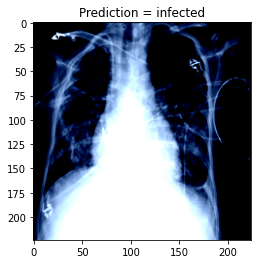

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ========> Worst Classified <======== 


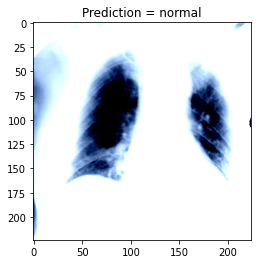

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


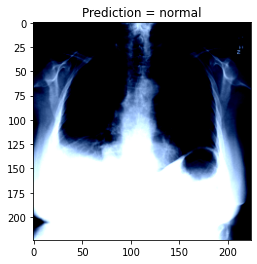

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).





FOR NORMAL CLASS
******************************************************************************************
 ========> Best Classified <======== 


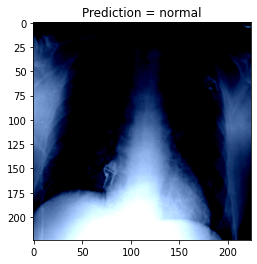

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


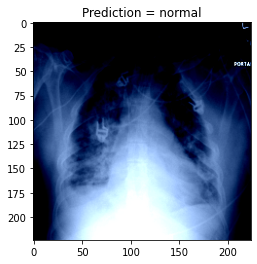

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ========> Worst Classified <======== 


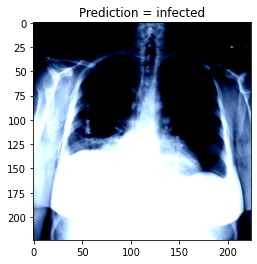

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


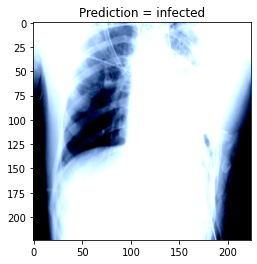

In [0]:
# Plotting well and worst classified images

print('FOR INFECTED CLASS')
print(' ========> Best Classified <======== ')
plt.imshow(np.array(test_data[inf_true[0]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[0])
plt.show()

plt.imshow(np.array(test_data[inf_true[1]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[0])
plt.show()

print('\n ========> Worst Classified <======== ')
plt.imshow(np.array(test_data[inf_false[0]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[1])
plt.show()

plt.imshow(np.array(test_data[inf_false[1]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[1])
plt.show()

print('\n\n')
print('FOR NORMAL CLASS')
print('*'*90)
print(' ========> Best Classified <======== ')
plt.imshow(np.array(test_data[nor_true[0]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[1])
plt.show()

plt.imshow(np.array(test_data[nor_true[1]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[1])
plt.show()

print('\n ========> Worst Classified <======== ')
plt.imshow(np.array(test_data[nor_false[0]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[0])
plt.show()

plt.imshow(np.array(test_data[nor_false[1]][0]).transpose((1, 2, 0)))
plt.title('Prediction = '+class_names[0])
plt.show()